# Gradient Boosted Trees: Model understanding.
For an end-to-end walkthrough of training a Gradient Boosting model check out the boosted trees tutorial. In this tutorial you will:
- Learn how to interpret a Boosted Tree model both locally and globally
- Gain intution for how a Boosted Trees model fits a dataset

## How to interpret Boosted Trees models both locally and globally
Local interpretability refers to an understanding of a model’s predictions at the individual example level, while global interpretability refers to an understanding of the model as a whole. Such techniques can help machine learning (ML) practitioners detect bias and bugs during the model development stage

For local interpretability, you will learn how to create and visualize per-instance contributions. To distinguish this from feature importances, we refer to these values as directional feature contributions (DFCs).

For global interpretability you will retrieve and visualize gain-based feature importances, permutation feature importances and also show aggregated DFCs.

In [35]:
from __future__ import absolute_import, division, print_function

import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
sns_colors = sns.color_palette('colorblind')

tf.logging.set_verbosity(tf.logging.ERROR)
tf.set_random_seed(123)

In [36]:
# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tfbt/titanic_train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tfbt/titanic_eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

## Create feature columns, input_fn, and the train the estimator
### Preprocess the data
Create the feature columns, using the original numeric columns as is and one-hot-encoding categorical variables.

In [37]:
fc = tf.feature_column
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']
  
def one_hot_cat_column(feature_name, vocab):
  return fc.indicator_column(
      fc.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  # Need to one-hot encode categorical features.
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(one_hot_cat_column(feature_name, vocabulary))
  
for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(fc.numeric_column(feature_name,
                                           dtype=tf.float32))

### Build the input pipeline
Create the input functions using the from_tensor_slices method in the tf.data API to read in data directly from Pandas.

In [38]:
# Use entire batch since this is such a small dataset.
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((X.to_dict(orient='list'), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    # For training, cycle thru dataset as many times as need (n_epochs=None).    
    dataset = (dataset
      .repeat(n_epochs)
      .batch(NUM_EXAMPLES)) 
    return dataset
  return input_fn

# Training and evaluation input functions.
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, n_epochs=1, shuffle=False)

### Train the model

In [39]:
params = {
  'n_trees': 50,
  'max_depth': 3,
  'n_batches_per_layer': 1,
  # You must enable center_bias = True to get DFCs. This will force the model to 
  # make an initial prediction before using any features (e.g. use the mean of 
  # the training labels for regression or log odds for classification when
  # using cross entropy loss).
  'center_bias': True
}

est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)
est.train(train_input_fn, max_steps=100)
results = est.evaluate(eval_input_fn)
pd.Series(results).to_frame()

,0
accuracy,0.806818
accuracy_baseline,0.625000
auc,0.866912
auc_precision_recall,0.845375
average_loss,0.421325
label/mean,0.375000
loss,0.421325
precision,0.755319
prediction/mean,0.385955
recall,0.717172


## Model interpretation and plotting
### Local interpretability
Next you will output the directional feature contributions (DFCs) to explain individual predictions using the approach outlined in Palczewska et al and by Saabas in Interpreting Random Forests (this method is also available in scikit-learn for Random Forests in the treeinterpreter package). The DFCs are generated with:

pred_dicts = list(est.experimental_predict_with_explanations(pred_input_fn))

(Note: The method is named experimental as we may modify the API before dropping the experimental prefix.)

In [40]:
pred_dicts = list(est.experimental_predict_with_explanations(eval_input_fn))

# Create DFC Pandas dataframe.
labels = y_eval.values
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])
df_dfc.describe().T

,count,mean,std,min,25%,50%,75%,max
0,264.0,-0.026862,0.082829,-0.139371,-0.076842,-0.052102,0.002211,0.386390
1,264.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,264.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,264.0,0.038581,0.077524,-0.043241,0.000000,0.000000,0.018794,0.223820
4,264.0,-0.021848,0.028343,-0.064875,-0.045993,-0.044929,-0.006919,0.035927
5,264.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,264.0,-0.017042,0.020665,-0.041092,-0.036772,-0.033420,0.000000,0.019316
7,264.0,0.000774,0.003590,-0.017902,0.000000,0.000000,0.000000,0.009702
8,264.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,264.0,-0.000684,0.003031,-0.006781,0.000000,0.000000,0.000000,0.027132


In [41]:
# A nice property of DFCs is that the sum of the contributions + the bias 
# is equal to the prediction for a given example.
# Sum of DFCs + bias == probabality.
bias = pred_dicts[0]['bias']
dfc_prob = df_dfc.sum(axis=1) + bias
np.testing.assert_almost_equal(dfc_prob.values,
                               probs.values)

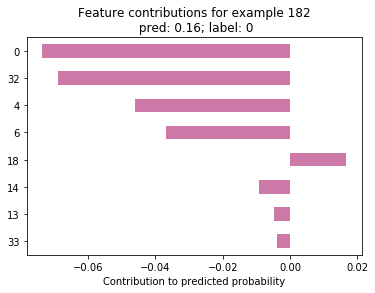

In [42]:
# Plot results.
ID = 182
example = df_dfc.iloc[ID]  # Choose ith example from evaluation set.
TOP_N = 8  # View top 8 features.
sorted_ix = example.abs().sort_values()[-TOP_N:].index
ax = example[sorted_ix].plot(kind='barh', color=sns_colors[3])
ax.grid(False, axis='y')

ax.set_title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
ax.set_xlabel('Contribution to predicted probability');

The larger magnitude contributions have a larger impact on the model's prediction. Negative contributions indicate the feature value for this given example reduced the model's prediction, while positive values contribute an increase in the prediction.

### Improved plotting
Let's make the plot nice by color coding based on the contributions' directionality and add the feature values on figure.

In [44]:
# Boilerplate code for plotting :)
def _get_color(value):
    """To make positive DFCs plot green, negative DFCs plot red."""
    green, red = sns.color_palette()[2:4]
    if value >= 0: return green
    return red

def _add_feature_values(feature_values, ax):
    """Display feature's values on left of plot."""
    x_coord = ax.get_xlim()[0]
    OFFSET = 0.15
    for y_coord, (feat_name, feat_val) in enumerate(feature_values.items()):
        t = plt.text(x_coord, y_coord - OFFSET, '{}'.format(feat_val), size=12)
        t.set_bbox(dict(facecolor='white', alpha=0.5))
    from matplotlib.font_manager import FontProperties
    font = FontProperties()
    font.set_weight('bold')
    t = plt.text(x_coord, y_coord + 1 - OFFSET, 'feature\nvalue',
    fontproperties=font, size=12)
    
def plot_example(example):
  TOP_N = 8 # View top 8 features.
  sorted_ix = example.abs().sort_values()[-TOP_N:].index  # Sort by magnitude.
  example = example[sorted_ix]
  colors = example.map(_get_color).tolist()
  ax = example.to_frame().plot(kind='barh',
                          color=[colors],
                          legend=None,
                          alpha=0.75,
                          figsize=(10,6))
  ax.grid(False, axis='y')
  ax.set_yticklabels(ax.get_yticklabels(), size=14)

  # Add feature values.
  _add_feature_values(dfeval.iloc[ID][sorted_ix], ax)
  return ax

IndexError: index 33 is out of bounds for axis 0 with size 9

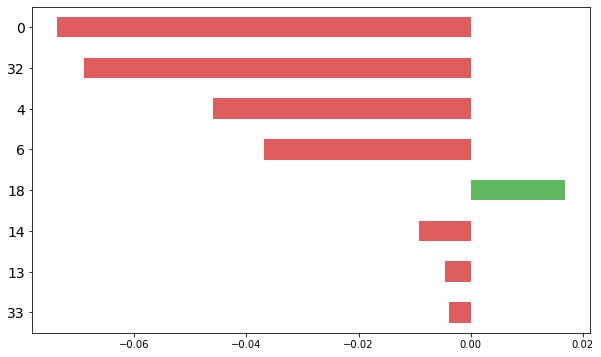

In [46]:
example = df_dfc.iloc[ID]  # Choose IDth example from evaluation set.
ax = plot_example(example)
ax.set_title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
ax.set_xlabel('Contribution to predicted probability', size=14);

In [47]:
# Boilerplate plotting code.
def dist_violin_plot(df_dfc, ID):
  # Initialize plot.
  fig, ax = plt.subplots(1, 1, figsize=(10, 6))
  
  # Create example dataframe.
  TOP_N = 8  # View top 8 features.
  example = df_dfc.iloc[ID]
  ix = example.abs().sort_values()[-TOP_N:].index
  example = example[ix]
  example_df = example.to_frame(name='dfc')
  
  # Add contributions of entire distribution.
  parts=ax.violinplot([df_dfc[w] for w in ix],
                 vert=False,
                 showextrema=False,
                 widths=0.7,
                 positions=np.arange(len(ix)))
  face_color = sns_colors[0]
  alpha = 0.15
  for pc in parts['bodies']:
      pc.set_facecolor(face_color)
      pc.set_alpha(alpha)
  
  # Add feature values.
  _add_feature_values(dfeval.iloc[ID][sorted_ix], ax)

  # Add local contributions.
  ax.scatter(example,
              np.arange(example.shape[0]),
              color=sns.color_palette()[2],
              s=100,
              marker="s",
              label='contributions for example')
  
  # Legend
  # Proxy plot, to show violinplot dist on legend.
  ax.plot([0,0], [1,1], label='eval set contributions\ndistributions',
          color=face_color, alpha=alpha, linewidth=10)
  legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large',
                     frameon=True)
  legend.get_frame().set_facecolor('white')
  
  # Format plot.
  ax.set_yticks(np.arange(example.shape[0]))
  ax.set_yticklabels(example.index)
  ax.grid(False, axis='y')
  ax.set_xlabel('Contribution to predicted probability', size=14)

IndexError: index 33 is out of bounds for axis 0 with size 9

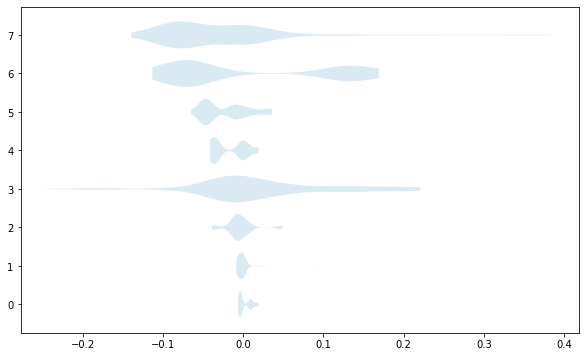

In [48]:
dist_violin_plot(df_dfc, ID)
plt.title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]));

## Global feature importances
Additionally, you might want to understand the model as a whole, rather than studying individual predictions. Below, you will compute and use:

1 - Gain-based feature importances using est.experimental_feature_importances

2 - Permutation importances

3 - Aggregate DFCs using est.experimental_predict_with_explanations

Gain-based feature importances measure the loss change when splitting on a particular feature, while permutation feature importances are computed by evaluating model performance on the evaluation set by shuffling each feature one-by-one and attributing the change in model performance to the shuffled feature.

In general, permutation feature importance are preferred to gain-based feature importance, though both methods can be unreliable in situations where potential predictor variables vary in their scale of measurement or their number of categories and when features are correlated (source). Check out this article for an in-depth overview and great discussion on different feature importance types.

### 1 - Gain-based feature importances
Gain-based feature importances are built into the TensorFlow Boosted Trees estimators using est.experimental_feature_importances.

In [50]:
importances = est.experimental_feature_importances(normalize=True)
df_imp = pd.Series(importances)

# Visualize importances.
N = 8
ax = (df_imp.iloc[0:N][::-1]
    .plot(kind='barh',
          color=sns_colors[0],
          title='Gain feature importances',
          figsize=(10, 6)))
ax.grid(False, axis='y')

TypeError: Empty 'DataFrame': no numeric data to plot